In [1]:
#https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

In [1]:
from sentic import SenticPhrase
import sentic
import senticnet
import pandas as pd
import seaborn as sns
import re
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
import string
#import gensim.downloader as api
import spacy
import stanza
#nlp = spacy.load("en_core_web_sm")
import nltk
import ssl
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import pos_tag

In [3]:
#list(df.columns)

In [2]:
#df = pd.read_csv("datos_train.csv",sep = ',')
df = pd.read_excel("datos_features.xlsx")
#df.head(2)

###### Extracción de sentimiento con Stanza ( 0 - Negativo, 1 - Neutro, 2 - Positivo)

The SentimentProcessor adds a label for sentiment to each Sentence. The existing models each support negative, neutral, and positive, represented by 0, 1, 2 respectively.

In [9]:
t = df['text']
t = t[0:10]
#t

0    TENNESSEE: We're the best state. Nobody even c...
1    A man inserted an advertisement in the classif...
2    How many men does it take to open a can of bee...
3    Told my mom I hit 1200 Twitter followers. She ...
4    Roses are dead. Love is fake. Weddings are bas...
5    'Trabajo,' the Spanish word for work, comes fr...
6    I enrolled on some skill training and extra cu...
7    ME: I'm such an original. Truly one of a kind....
8    Men who ejaculated 21 times or more a month ha...
9    I got REALLY angry today and it wasn't about n...
Name: text, dtype: object

In [21]:
def sentiment_stanza(t):
    
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
    
    for i in range(len(t)):
        token = nlp(t[i])
        for i, sentence in enumerate(token.sentences):
            yield sentence.sentiment #The sentiment value for this sentence, as a string
            #print(sentence.sentiment)

In [24]:
t = df['texto_limpio']
sentimiento_stanza = sentiment_stanza(t)

In [25]:
sentimientoStanza = []
for i in sentimiento_stanza:
    sentimientoStanza.append(i)
df['sentimiento_stanza'] = sentimientoStanza
#df.head()

2022-06-07 08:59:53 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-06-07 08:59:53 INFO: Use device: cpu
2022-06-07 08:59:53 INFO: Loading: tokenize
2022-06-07 08:59:53 INFO: Loading: sentiment
2022-06-07 08:59:53 INFO: Done loading processors!


##### Polarity average feature with Sentic
Analiza como el sentimiento fluye de concepto en concepto a través de relaciones de dependencia para un mejor entendimiento del rol contextual de cada concepto en el texto y conseguir una inferencia dinámica de la polaridad que mejore los métodos estadísticos del estado del arte en términod de accuracy y tiempo de train.

In [29]:
#https://pypi.org/project/sentic/

polaridad_sentic = [] 

t = df['text']
for i in range(len(t)):
    sentence = t[i] #.split()
            
    try:
        sp = SenticPhrase(sentence)
        polaridad = sp.get_polarity()
                      
    except KeyError:
        print(sentence)
        continue
    polaridad_sentic.append(polaridad)

In [32]:
df['polaridad_media_sentic'] = polaridad_sentic

In [35]:
df["polaridad_media_sentic"].head()

0    0.1120
1    0.4040
2    0.2280
3    0.0070
4   -0.0575
Name: polaridad_media_sentic, dtype: float64

#### https://www.kaggle.com/yommnamohamed/sentiment-analysis-using-sentiwordnet

#### Sentiment with SentiWordNet

SentiWordNet is an opinion lexicon derived from the WordNet database where each term is associated with numerical scores indicating positive and negative sentiment information. 
usa nltk.
para cada token con su part-of-speech, se obtiene su score (pos, neg y neu) relacionado al tag que tenga la palabra. se tiene en cuenta su contexto.
Pos(s) + Neg(s) + Obj(s) = 1
ej: si una oración tiene un score neg de 0.5, y scores 0 para pos y neu, su score resultante será 1 (negativo)

In [90]:
pos=0
neg=0
obj=0
count=0
texto = df['texto_limpio']
postagging = []

for i in range(len(texto)):
    words = texto[i].split()
    postagging.append(nltk.pos_tag(words))

def tags(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word,tag):
    word_tags = tags(tag)
    
    if word_tags not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    """lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []"""
    
    synsets = wn.synsets(word, pos=word_tags)
    if not synsets:
        return []
    
    #tomo el primer sinónimo, el más común
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())
    
    #print([synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()][0:5])
    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [91]:
pos=0
neg=0
obj=0
count=0

senti_score = []

for pos_val in postagging:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    

In [93]:
df['sentiwordnet_score'] = senti_score
overall=[]
for i in range(len(texto)):
    if df['sentiwordnet_score'][i]>= 0.05:
        overall.append('Positive')
    elif df['sentiwordnet_score'][i]<= -0.05:
        overall.append('Negative')
    else:
        overall.append('Neutral')
df['sentiwordnet_overall_Sentiment'] = overall

In [27]:
df['sentiwordnet_score'].describe()

count    8000.000000
mean       -0.146405
std         0.718333
min        -4.500000
25%        -0.625000
50%         0.000000
75%         0.250000
max         3.875000
Name: sentiwordnet_score, dtype: float64

In [16]:
synset = wn.synsets('love', pos=wn.ADJ)


In [12]:
synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()

('ugly.a.01', 0.0, 0.375, 0.625)

##### Sentiment VADER

model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.The sentiment score of a text can be obtained by summing up the intensity of each word in the text.
sentiment score is measured on a scale from -4 to +4, where -4 is the most negative and +4 is the most positive. The midpoint 0 represents a neutral sentiment.
uso compound score. resumiendo los valence scores de cada pal en el lexicon, ajustandolo según las reglas y normalizandolo entre -1(muy neg) a 1(muy pos). útil si se quiere una metrica unidimensional del sentimiento de una oración, siendo el 'score ponderado normalizado'

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_vader(texto):
    
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    
    #for i, sentence in enumerate(texto):
    sentiment_dict = sid_obj.polarity_scores(texto)
    '''  negative = sentiment_dict['neg']
        neutral = sentiment_dict['neu']
        positive = sentiment_dict['pos'] '''
    
    return sentiment_dict['compound']

df['vader_score_sentiment'] = df['texto_limpio'].apply(sentiment_vader)

In [4]:
df['vader_score_sentiment_normal'] = df['text'].apply(sentiment_vader)

In [28]:
df['vader_score_sentiment'].unique()

array([-0.1779,  0.5574,  0.    , ..., -0.8527, -0.343 , -0.2635])

In [5]:
df['vader_score_sentiment_normal'].unique()

array([ 0.1531,  0.5106,  0.    , ..., -0.7235,  0.1759, -0.2635])

In [7]:
def tag(score):
    
    if score >= 0.05:
        return 'postive'
    elif score <= - 0.05: 
        return 'negative'
    else:
        return 'neutral'

df['vader_tag_sentiment_normal'] = df['vader_score_sentiment_normal'].apply(tag)

/Users/luciainesmerlo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/luciainesmerlo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vader_score_sentiment_normal', ylabel='Density'>

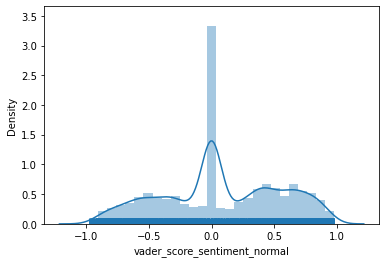

In [6]:
#ax=sns.displot(data=df, x="vader_score_sentiment",kind="kde",fill=True)
#ax#.set(xlim=(-0.05e16,0.05e16))
ax = sns.distplot(df['vader_score_sentiment_normal'], rug=True
                 )
ax

<AxesSubplot:xlabel='vader_score_sentiment', ylabel='Count'>

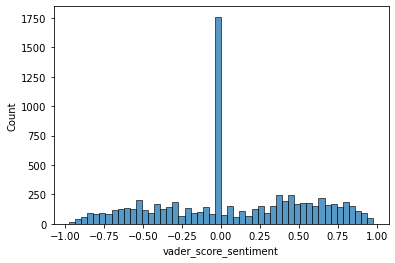

In [25]:
ax=sns.histplot(df["vader_score_sentiment"],bins=50,kde=False)
ax

<AxesSubplot:xlabel='vader_tag_sentiment', ylabel='count'>

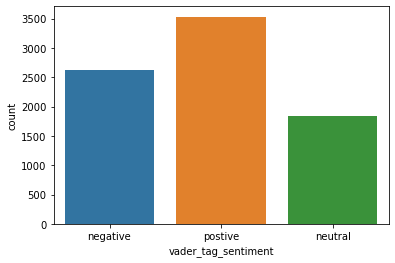

In [23]:
ax=sns.countplot(data=df, x="vader_tag_sentiment")
ax

##### Emotions and sentiment scores with TextBlob 


As TextBlob is a Lexicon-based sentiment analyzer It has some predefined rules or we can say word and weight dictionary, where it has some scores that help to calculate a sentence's polarity. That's why the Lexicon-based sentiment analyzers are also called “Rule-based sentiment analyzers”.

Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.
TextBlob calculates subjectivity by looking at the ‘intensity’. Intensity determines if a word modifies the next word. For English, adverbs are used as modifiers (‘very good’).

In [10]:
"""
Polarity, in simple terms, means emotions expressed in a 
sentence – negative vs. positive
Subjectivity expresses some personal feelings, views, or 
beliefs – objective vs. subjective
"""

#call the classifier
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
    
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [11]:
df['subjectivity_score_textblob'] = df['text'].apply(getSubjectivity) 
df['polarity_score_textblob'] = df['texto_limpio'].apply(getPolarity) 
df['tag_score_textblob'] = df['polarity_score_textblob'].apply(analysis)

In [82]:
#ax=sns.displot(data=df, x="subjectivity_score_textblob",kind="kde",fill=True)
#ax#.set(xlim=(-0.05e16,0.05e16))

<AxesSubplot:xlabel='subjectivity_score_textblob', ylabel='Count'>

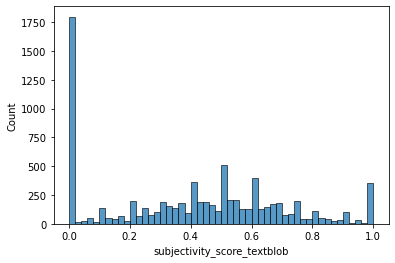

In [26]:
ax=sns.histplot(df["subjectivity_score_textblob"],bins=50,kde=False)
ax

In [83]:
#ax=sns.displot(data=df, x="polarity_score_textblob",kind="kde",fill=True)
#ax#.set(xlim=(-0.05e16,0.05e16))

<AxesSubplot:xlabel='polarity_score_textblob', ylabel='Count'>

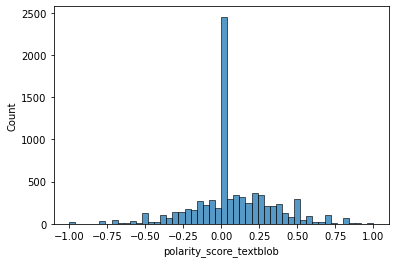

In [27]:
ax=sns.histplot(df["polarity_score_textblob"],bins=50,kde=False)
ax

/Users/luciainesmerlo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tag_score_textblob', ylabel='count'>

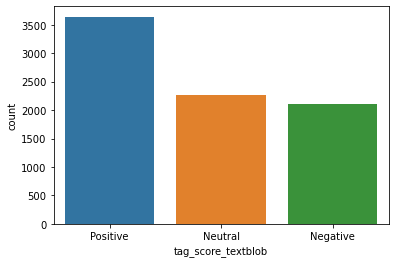

In [27]:
sns.countplot(df['tag_score_textblob'])

In [12]:
import os
df.to_excel('/Users/luciainesmerlo/Desktop/TFG/HaHackaton2020/LABELEDdatos_features.xlsx')
#df.to_csv('/Users/luciainesmerlo/Desktop/TFG/HaHackaton2020/datos_train.csv', sep=',')